In [1]:
! pip install pandas
! pip install boto3
! pip install watchtower
! pip install s3fs==0.4.2
! pip install pyathena
! pip install matplotlib
! pip install scipy
! pip install ipywidgets
! pip install scikit-learn

! conda install -c conda-forge --yes implicit 

! pip install --upgrade jupyter_client # useful to make ipywidgets work properly when fitting data with implicit

# pip install git+https://gitlab.com/cloena/cloena-aws-tools.git

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [39]:
! conda install -c conda-forge --yes implicit 

! pip install --upgrade jupyter_client

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::pyopenssl==19.1.0=py36_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/noarch::boto3==1.9.162=py_0
  - defaults/linux-64::s3transfer==0.2.1=py36_0
  - defaults/linux-64::nbconvert

In [1]:
import pandas as pd

import implicit

import matplotlib

import re

import scipy

from ipywidgets import FloatProgress

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import json

from io import StringIO # python3; python2: BytesIO 
import boto3
import csv

from pyathena import connect

In [2]:
from aws_tools import athena_tools, s3_tools

/home/ec2-user/.local/lib/python3.6/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')


In [3]:
dev = '_dev'

In [4]:
# create a connection to Athena
conn = connect(s3_staging_dir = 's3://aws-athena-query-results-341377015103-eu-west-2/',
                   region_name='eu-west-2') 

### Assemble the 'views' data

In [5]:
query = '''
DROP TABLE IF EXISTS bt_home_ds.bt_tv_recommendation_engine_data_views''' + dev + ''';
'''
pd.read_sql(query, conn)

query = '''
CREATE TABLE IF NOT EXISTS bt_home_ds.bt_tv_recommendation_engine_data_views''' + dev + ''' AS
SELECT
    vs.VISION_SERVICE_ID AS id_user -- account ID
    ,vs.CI_ASSET_TYPE AS TYPE_ASSET -- e.g. Film, Music, etc.
    ,vs.VIEW_TIME_ST AS EVENT_DATE -- time of event
    
    ,COALESCE(ps2.EDITORIAL_VERSION_ID, ps1.EDITORIAL_VERSION_ID) AS id_editorial -- identifies multiple instances of same film/season/episode, e.g. rent/purchase & SD/HD
    
    ,COALESCE(ps2.CI_TITLE, ps1.CI_TITLE) AS TITLE --  human readable title
    ,COALESCE(ps2.CI_TYPE, ps1.CI_TYPE) AS TYPE -- type, like film/music/episode/season/collection
    ,COALESCE(ps2.CI_AVAILABLE_END_DT, ps1.CI_AVAILABLE_END_DT) AS END_DATE -- date until availability of item
    ,COALESCE(ps2.CI_AVAILABLE_START_DT, ps1.CI_AVAILABLE_START_DT) AS START_DATE -- start date of availability of item
    
    ,COALESCE(ps2.GENRE, ps1.GENRE) AS GENRE
    ,COALESCE(ps2.rating, ps1.rating) AS rating
      
    ,'VIEW' AS type_entitlement
    
FROM
    bt_home_datamart.l_edw_vod_views vs

-- perform an inner join of the events with the catalogue to get the product id for each entry:
-- this is needed to later match the product id with the parent id and group episodes into seasons
INNER JOIN 
    bt_home_datamart.l_edw_vod_products ps1
ON
     vs.CONTENT_ID = ps1.PRODUCT_GUID

-- perform left join to match ID_PARENT with product id where available:
-- this will give either the same element due to the coalesce OR the actual parent, i.e. the season rather than the episode
LEFT JOIN 
   bt_home_datamart.l_edw_vod_products ps2
ON
   ps1.CI_PARENTGUID = ps2.PRODUCT_GUID 

WHERE vs.EVENT_SLOT_TYPE = 'Feature'
AND vs.VISION_SERVICE_ID IS NOT NULL
AND ps1.EDITORIAL_VERSION_ID IS NOT NULL;
'''
pd.read_sql(query, conn)

,rows


In [6]:
query = '''
DROP TABLE IF EXISTS bt_home_ds.bt_tv_recommendation_engine_data_views_maxenddt''' + dev + ''';
'''
pd.read_sql(query, conn)

query = '''
CREATE TABLE IF NOT EXISTS bt_home_ds.bt_tv_recommendation_engine_data_views_maxenddt''' + dev + ''' AS
SELECT 
    aaa.id_user -- account ID
    ,aaa.TYPE_ASSET -- e.g. Film, Music, etc.
    ,aaa.EVENT_DATE -- time of event
    
    ,aaa.id_editorial -- identifies multiple instances of same film/season/episode, e.g. rent/purchase & SD/HD
    
    ,aaa.TITLE --  human readable title
    ,aaa.TYPE -- type, like film/music/episode/season/collection
    
    ,COALESCE(ps.CI_AVAILABLE_END_DT, aaa.END_DATE) AS END_DATE -- date until availability of item
    ,aaa.START_DATE -- start date of availability of item
    
    ,aaa.GENRE
    ,aaa.rating
    
    ,aaa.type_entitlement -- TVOD / EVOD / PPV

FROM bt_home_ds.bt_tv_recommendation_engine_data_views''' + dev + ''' aaa

-- left join with catalogue again where we keep only max availability date for each editorial id
LEFT JOIN
    (SELECT EDITORIAL_VERSION_ID, MAX(DATE(CI_AVAILABLE_END_DT)) AS CI_AVAILABLE_END_DT
    FROM bt_home_datamart.l_edw_vod_products 
    GROUP BY EDITORIAL_VERSION_ID) ps
ON 
    aaa.id_editorial = ps.EDITORIAL_VERSION_ID;
'''
pd.read_sql(query, conn)

,rows


In [7]:
query = '''
SELECT *
FROM bt_home_ds.bt_tv_recommendation_engine_data_views_maxenddt''' + dev + ''';
'''

data_views = athena_tools.AthenaQuerier().execute_query(query=query)

2021-02-05 15:27:24,365 [INFO ]  starting Athena query ...
2021-02-05 15:36:13,775 [INFO ]  loading 247888e2-7ea0-40a5-9fdb-80256f82be1a.csv
2021-02-05 15:43:42,271 [INFO ]  Athena query complete: returning dataframe


### Assemble the 'purchase'/'rental'/'PPV' data

In [8]:
query = '''
DROP TABLE IF EXISTS bt_home_ds.bt_tv_recommendation_engine_data_prps''' + dev + ''';
'''
pd.read_sql(query, conn)

query = '''
CREATE TABLE IF NOT EXISTS bt_home_ds.bt_tv_recommendation_engine_data_prps''' + dev + ''' AS
SELECT
    vs.VISION_SERVICE_ID AS id_user -- account ID
    ,vs.CI_ASSET_TYPE AS TYPE_ASSET -- e.g. Film, Music, etc.
    ,vs.PURCHASE_TIME_ST AS EVENT_DATE -- time of event
    
    ,COALESCE(ps2.EDITORIAL_VERSION_ID, ps1.EDITORIAL_VERSION_ID) AS id_editorial -- identifies multiple instances of same film/season/episode, e.g. rent/purchase & SD/HD
    
    ,COALESCE(ps2.CI_TITLE, ps1.CI_TITLE) AS TITLE --  human readable title
    ,COALESCE(ps2.CI_TYPE, ps1.CI_TYPE) AS TYPE -- type, like film/music/episode/season/collection
    
    ,COALESCE(ps2.CI_AVAILABLE_END_DT, ps1.CI_AVAILABLE_END_DT) AS END_DATE -- date until availability of item
    ,COALESCE(ps2.CI_AVAILABLE_START_DT, ps1.CI_AVAILABLE_START_DT) AS START_DATE -- start date of availability of item
    
    ,COALESCE(ps2.GENRE, ps1.GENRE) AS GENRE
    ,COALESCE(ps2.rating, ps1.rating) AS rating
    
    ,vs.ENTITLEMENT_TYPE AS type_entitlement -- TVOD / EVOD / PPV
    
FROM
    bt_home_datamart.l_edw_vod_purchases vs

-- perform an inner join of the events with the catalogue to get the product id for each entry:
-- this is needed to later match the product if with the parent id and group episodes into seasons
INNER JOIN 
    bt_home_datamart.l_edw_vod_products ps1
ON
    vs.PRODUCT_ID = ps1.PRODUCT_GUID

-- perform left join to match ID_PARENT with product id where available:
-- this will give either the same element due to the coalesce OR the actual parent, i.e. the season rather than the episode
LEFT JOIN 
   bt_home_datamart.l_edw_vod_products ps2
ON
   ps1.CI_PARENTGUID = ps2.PRODUCT_GUID 

WHERE vs.VISION_SERVICE_ID IS NOT NULL
AND ps1.EDITORIAL_VERSION_ID IS NOT NULL;
'''
pd.read_sql(query, conn)

,rows


In [9]:
query = '''
DROP TABLE IF EXISTS bt_home_ds.bt_tv_recommendation_engine_data_prps_maxenddt''' + dev + ''';
'''
pd.read_sql(query, conn)

query = '''
CREATE TABLE IF NOT EXISTS bt_home_ds.bt_tv_recommendation_engine_data_prps_maxenddt''' + dev + ''' AS
SELECT
    aaa.id_user -- account ID
    ,aaa.TYPE_ASSET -- e.g. Film, Music, etc.
    ,aaa.EVENT_DATE -- time of event
    
    ,aaa.id_editorial -- identifies multiple instances of same film/season/episode, e.g. rent/purchase & SD/HD
    
    ,aaa.TITLE --  human readable title
    ,aaa.TYPE -- type, like film/music/episode/season/collection
    
    ,COALESCE(ps.CI_AVAILABLE_END_DT, aaa.END_DATE) AS END_DATE -- date until availability of item
    ,aaa.START_DATE -- start date of availability of item
    
    ,aaa.GENRE
    ,aaa.rating
    
    ,aaa.type_entitlement -- TVOD / EVOD / PPV
    
FROM
    bt_home_ds.bt_tv_recommendation_engine_data_prps''' + dev + ''' aaa

-- left join with catalogue again where we keep only max availability date for each editorial id
LEFT JOIN
    (SELECT EDITORIAL_VERSION_ID, MAX(DATE(CI_AVAILABLE_END_DT)) AS CI_AVAILABLE_END_DT
    FROM bt_home_datamart.l_edw_vod_products 
    GROUP BY EDITORIAL_VERSION_ID) ps
ON 
    aaa.id_editorial = ps.EDITORIAL_VERSION_ID;
'''
pd.read_sql(query, conn)

,rows


In [10]:
query = '''
SELECT *
FROM bt_home_ds.bt_tv_recommendation_engine_data_prps_maxenddt''' + dev + ''';
'''

data_prps = athena_tools.AthenaQuerier().execute_query(query=query)

2021-02-05 15:44:16,749 [INFO ]  starting Athena query ...
2021-02-05 15:44:40,413 [INFO ]  loading 4727b51b-8518-4bc7-8390-fbffa7d00382.csv
2021-02-05 15:44:53,786 [INFO ]  Athena query complete: returning dataframe


### Model Data Prep

In [11]:
data_implicit = data_views.append(data_prps, ignore_index=True) 

In [12]:
del data_views
del data_prps

In [13]:
data_implicit.head(1)

,id_user,type_asset,event_date,id_editorial,title,type,end_date,start_date,genre,rating,type_entitlement
0,V3009013118,episode,2019-10-26 12:26:56,movida_10070063,Teen Mom: Young & Pregnant UK Series 1,season,2020-12-10,2018-12-10 03:38:00,Entertainment,pg,VIEW


In [14]:
data_implicit['type_asset'].unique()

array(['episode', 'music', 'film', 'Sport', 'Kids', 'TV Replay', 'Film',
       'TV', 'preview', 'Promotion', 'Music', nan], dtype=object)

In [15]:
DROP_MUSIC = True
if DROP_MUSIC:
    data_implicit = data_implicit[(data_implicit['type_asset'] != 'Music') & (data_implicit['type_asset'] != 'music')]
else:
    pass

In [16]:
# Richard's export from the hackathon
# season_to_brand_map = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/SeasonToBrandMapping-NoExpired.csv')

In [17]:
season_to_brand_map = pd.read_csv('s3://bt-data-science-playground/bt-tv-recommendation-system/model_objects/SeasonToBrandMapping.csv')

In [18]:
season_to_brand_map.head() 

,SEASON_GUID,BRAND_GUID
0,movida_10002812,movida_16370
1,movida_10071830,movida_18508
2,movida_10020242,movida_15374
3,movida_10086096,movida_16208
4,movida_10013947,movida_18907


In [19]:
def season_to_brand(df, df_map):
    df = df.merge(df_map, how='left', left_on = 'id_editorial', right_on = 'SEASON_GUID')
    df['BRAND_GUID'].fillna(df['id_editorial'], inplace=True)
    df['id_editorial'] = df['BRAND_GUID']
    df.drop(['SEASON_GUID', 'BRAND_GUID'], axis=1, inplace=True)
    
    return df

In [20]:
data_implicit = season_to_brand(data_implicit, season_to_brand_map)

In [21]:
# Calculate sparsity 
n_users = data_implicit['id_user'].unique().shape[0]
n_items = data_implicit['id_editorial'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(data_implicit.shape[0]) / float(n_users*n_items) * 100))

Number of users: 1075205
Number of items: 19320
Sparsity: 0.347%


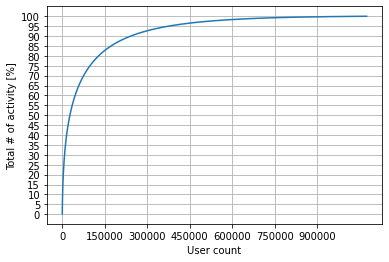

In [22]:
# Calculate how many users have watched X% of the content
idx = data_implicit['id_user'].value_counts().index.tolist()
counts = data_implicit['id_user'].value_counts().tolist()

user_count = []
percentage_activity = []
activity_so_far = 0
total_activity = sum(counts)

for u in range(len(idx)):
    
    user_count.append(u+1)
    
    activity_so_far = activity_so_far + counts[u]
    percentage_so_far = activity_so_far / total_activity * 100
    percentage_activity.append(percentage_so_far)
     
import matplotlib.pyplot as plt

plt.plot(user_count, percentage_activity)
plt.xlabel('User count')
plt.ylabel('Total # of activity [%]')
plt.grid()
plt.yticks(np.arange(0,105, 5))
plt.xticks(np.arange(0,1000000, 150000))
plt.show()

In [23]:
data_implicit['type_entitlement'].value_counts()

VIEW    69228109
TVOD     1831182
EVOD      962999
PPV        98523
Name: type_entitlement, dtype: int64

In [24]:
# based on type of entitlement (purchase/rental/ppv/view) give different strength [EVOD=purchase;TVOD=rental]
def assign_eventStrength(x):
    if x == 'EVOD':
        val = 3
    elif x == 'TVOD':
        val = 3
    elif x == 'PPV':
        val = 3
    elif x == 'VIEW':
        val = 1
    else:
        val = 1
    return val

data_implicit['eventStrength'] = data_implicit['type_entitlement'].apply(assign_eventStrength)

In [25]:
# Turn duplicate the rating column in a form that is numeric so that they can be compared
def rating_toNumeric(x):
    if x == 'u':
        return 0
    elif x == 'pg':
        return 1
    elif x == '12':
        return 2
    elif x == '15':
        return 3
    elif x == '18':
        return 4
    else:
        return 5
    
data_implicit['rating_n'] = data_implicit['rating'].apply(rating_toNumeric)

In [26]:
def type_production(x):
    if (x == 'season') or (x == 'episode'):
        return 'BRAND'
    elif x == 'collection':
        return 'COLLECTION'
    else:
        return 'PROGRAM'
    
data_implicit['type_production'] = data_implicit['type'].apply(type_production)

In [27]:
data_implicit.head()

,id_user,type_asset,event_date,id_editorial,title,type,end_date,start_date,genre,rating,type_entitlement,eventStrength,rating_n,type_production
0,V3009013118,episode,2019-10-26 12:26:56,movida_10070063,Teen Mom: Young & Pregnant UK Series 1,season,2020-12-10,2018-12-10 03:38:00,Entertainment,pg,VIEW,1,1,BRAND
1,V3007938192,episode,2019-10-26 15:43:04,movida_10070063,Teen Mom: Young & Pregnant UK Series 1,season,2020-12-10,2018-12-10 03:38:00,Entertainment,pg,VIEW,1,1,BRAND
2,V3008026616,episode,2019-10-26 12:53:51,movida_10070063,Teen Mom: Young & Pregnant UK Series 1,season,2020-12-10,2018-12-10 03:38:00,Entertainment,pg,VIEW,1,1,BRAND
3,V3005414703,episode,2019-10-26 10:47:48,movida_10070063,Teen Mom: Young & Pregnant UK Series 1,season,2020-12-10,2018-12-10 03:38:00,Entertainment,pg,VIEW,1,1,BRAND
4,V3006463882,episode,2019-10-26 09:01:23,movida_16746,PJ Masks (Shorts) Series 99,season,2021-07-16,2019-07-16 02:07:00,2 - 5 Years,u,VIEW,1,0,BRAND


### Create the model

In [28]:
data_implicit['title'] = data_implicit['title'].astype("category")
data_implicit['id_user'] = data_implicit['id_user'].astype("category")
data_implicit['id_editorial'] = data_implicit['id_editorial'].astype("category")
data_implicit['id_user_simple'] = data_implicit['id_user'].cat.codes
data_implicit['id_editorial_simple'] = data_implicit['id_editorial'].cat.codes

data_implicit.head(1)

,id_user,type_asset,event_date,id_editorial,title,type,end_date,start_date,genre,rating,type_entitlement,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
0,V3009013118,episode,2019-10-26 12:26:56,movida_10070063,Teen Mom: Young & Pregnant UK Series 1,season,2020-12-10,2018-12-10 03:38:00,Entertainment,pg,VIEW,1,1,BRAND,940528,16548


In [29]:
sparse_content_person = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['id_editorial_simple'], data_implicit['id_user_simple']))
)
sparse_person_content = scipy.sparse.csr_matrix(
    (data_implicit['eventStrength'].astype(float), (data_implicit['id_user_simple'], data_implicit['id_editorial_simple']))
)

In [40]:
%%time

model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50, use_gpu=False)
alpha = 15
data_tofit = (sparse_content_person * alpha).astype('double')
model.fit(data_tofit)


CPU times: user 15min 59s, sys: 3.64 s, total: 16min 2s
Wall time: 1min 7s


In [31]:
# # Get the trained person and content vectors. We convert them to csr matrices
# person_vecs = scipy.sparse.csr_matrix(model.user_factors)
# content_vecs = scipy.sparse.csr_matrix(model.item_factors)

### Start making recommendations

In [99]:
id_editorial_legend = data_implicit[['id_editorial', 'id_editorial_simple', 'type_production', 'end_date', 'title']].drop_duplicates(subset=['id_editorial', 'id_editorial_simple']).sort_values(by='id_editorial_simple')

id_editorial_simple_list = id_editorial_legend['id_editorial_simple'].tolist()
id_editorial_list = id_editorial_legend['id_editorial'].tolist()
type_production_list = id_editorial_legend['type_production'].tolist()

# get array with 1 or 0 based on availability of content today
availability = id_editorial_legend['end_date'] > datetime.today().strftime('%Y-%m-%d')
availability = np.array(availability.astype(int))


id_user_legend = data_implicit[['id_user', 'id_user_simple']].drop_duplicates(subset=['id_user', 'id_user_simple']).sort_values(by='id_user_simple')
id_user_simple_list = id_user_legend['id_user_simple'].tolist()
id_user_list = id_user_legend['id_user'].tolist()

date_today = datetime.today().strftime('%Y-%m-%d')
code_version = 'v0.4'

In [100]:
len(id_editorial_legend)

19320

In [73]:
id_editorial_legend.head(3)

,id_editorial,id_editorial_simple,type_production,end_date,title
55485296,91103606071601,0,BRAND,2020-11-19,Day 3 - Highlights (1/2)
3923325,91103619271602,1,BRAND,2020-11-23,QF - Highlights (2/3)
1258095,91103624771601,2,BRAND,2020-11-22,SF - Highlights (1/3)


In [43]:
data_implicit[data_implicit['id_editorial_simple'] == 0].head()

,id_user,type_asset,event_date,id_editorial,title,type,end_date,start_date,genre,rating,type_entitlement,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
55485296,V3007409796,episode,2020-11-19 12:40:52,91103606071601,Day 3 - Highlights (1/2),episode,2020-11-19,2020-11-19,Snooker,u,VIEW,1,0,BRAND,642164,0
55485304,V2200005101,episode,2020-11-19 14:38:47,91103606071601,Day 3 - Highlights (1/2),episode,2020-11-19,2020-11-19,Snooker,u,VIEW,1,0,BRAND,45961,0
55485308,V3006058639,episode,2020-11-19 13:42:24,91103606071601,Day 3 - Highlights (1/2),episode,2020-11-19,2020-11-19,Snooker,u,VIEW,1,0,BRAND,482821,0


In [44]:
id_user_legend.head(3)

,id_user,id_user_simple
4551811,V1000000000,0
21406452,V1000000004,1
25325044,V1000000006,2


In [45]:
data_implicit['genre'].unique()

array(['Entertainment', '2 - 5 Years', 'Crime', 'Reality', 'Football',
       '6 Years +', nan, 'Comedy', 'Documentary', 'Drama', 'Nature',
       'Fishing', 'Action', 'Family', 'Horror', 'Animation', 'Sci-Fi',
       'Sport Film', 'Thriller', 'Musicals', 'Lifestyle', 'Boxing', 'UFC',
       'Rugby', 'Motoring', 'Watersports', 'Poker', 'Motor Sport',
       'Sci-Fi and Fantasy', 'Tennis', 'Pre-school', 'Fantasy', 'Cycling',
       'MotoGP', 'Cricket', 'Food', 'More Sport', 'Snooker', 'Wrestling',
       'Romance', 'Extreme', 'Athletics', 'Adventure', 'Factual',
       'Squash', 'Wintersports', 'eSports', 'Darts', 'Ice Hockey',
       'Western', 'Speedway', 'Hockey', 'Film', 'Aussie Rules Football',
       'Baby', 'Motorsport', 'All', 'World Cinema', 'Concert',
       'Water Sports', 'Basketball', 'Sports Documentary',
       'Champions League', 'Westerns', 'Golf', 'Sailing', 'Swimming',
       'Equestrian', 'Baseball'], dtype=object)

In [46]:
data_implicit['type_asset'].unique().tolist()

['episode',
 'film',
 'Sport',
 'Kids',
 'TV Replay',
 'Film',
 'TV',
 'preview',
 'Promotion',
 nan]

In [47]:
data_implicit['type'].unique().tolist()

['season', 'collection', 'episode', 'film', 'preview']

### Popular

In [52]:
# Film Store
n_days = 9

popular = data_implicit[(data_implicit['event_date'] + pd.DateOffset(n_days) >= date_today)
                        & (data_implicit['type_entitlement'] == 'EVOD') #TVOD
                        & (data_implicit['type'] == 'film')
                       ]['id_editorial_simple'].value_counts()

In [53]:
for i in popular.index.tolist()[:20]:
    print(data_implicit[data_implicit['id_editorial_simple'] == i]['title'].iloc[0])

Bill & Ted Face the Music
John Wick: Chapter 3 - Parabellum
The New Mutants
Wonder Woman
Mulan
Men in Black: International
Trolls: World Tour
The Call of the Wild
Fantastic Beasts: The Crimes of Grindelwald
Rocketman
Man of Steel
X-Men: Dark Phoenix
Kingsman: The Golden Circle
Sonic the Hedgehog
The Sixth Sense
The Roads Not Taken
Mission: Impossible - Fallout
Die Hard With a Vengeance
TENET
Jumanji: The Next Level


In [62]:
# TV Store
n_days = 9

popular = data_implicit[(data_implicit['event_date'] + pd.DateOffset(n_days) >= date_today)
                        & (data_implicit['type_entitlement'] != 'VIEW') 
                        & ((data_implicit['type'] == 'season') | (data_implicit['type'] == 'episode'))
                       ]['id_editorial_simple'].value_counts()

In [63]:
for i in popular.index.tolist()[:20]:
    print(data_implicit[data_implicit['id_editorial_simple'] == i]['title'].iloc[0])

Game of Thrones Series 6
The Walking Dead Series 10
Vikings: Pt2 Series 5
Fear the Walking Dead Series 1
Criminal Minds Series 13
Prodigal Son Series 1
Blaze and the Monster Machines Series 3
The Blacklist Series 5
Big Little Lies Series 2
Outlander Series 3
Blindspot Series 3
Band of Brothers Series 1
Supernatural Series 15
Warrior Series 1
The Sopranos Series 2
Room 104 Series 2
Succession Series 1
Euphoria Series 1
Snowfall Series 1
S.W.A.T. Series 3


In [80]:
# Kids
n_days = 4

popular = data_implicit[(data_implicit['event_date'] + pd.DateOffset(n_days) >= date_today)
                        #& (data_implicit['type_entitlement'] != 'VIEW') 
                        & (data_implicit['type_entitlement'] == 'VIEW') 
                        #& (data_implicit['type_asset'] == 'Kids')
                        & (data_implicit['genre'] == '6 Years +')
                       ]['id_editorial_simple'].value_counts()

In [81]:
for i in popular.index.tolist()[:20]:
    print(data_implicit[data_implicit['id_editorial_simple'] == i]['title'].iloc[0])

Alvinnn!!! and the Chipmunks Series 4
The Mr. Bean Animated Series Series 1
Grizzy & The Lemmings Series 1
Horrid Henry Series 4
SpongeBob SquarePants Series 9
Mr Bean
Teen Titans Go! Series 2
Regular Show Series 1
The Tom and Jerry Show Series 3
Angry Birds Blues Series 1
Henry Danger Series 5
SpongeBob SquarePants
What's New Scooby-Doo? Series 2
The Loud House Series 3
The Thundermans Series 3
Craig of the Creek Series 1
Find Me in Paris Series 2
We Bare Bears Series 2
Apple & Onion Series 1
Scooby-Doo!


In [90]:
# Sport
n_days = 9

popular = data_implicit[#(data_implicit['event_date'] + pd.DateOffset(n_days) >= date_today)
                        #& (data_implicit['type_entitlement'] != 'VIEW') 
                        #& (data_implicit['type_entitlement'] == 'VIEW') 
                        #& 
                        (data_implicit['type_asset'] == 'Sport')
                       ]['id_editorial_simple'].value_counts()

In [91]:
for i in popular.index.tolist()[:20]:
    print(data_implicit[data_implicit['id_editorial_simple'] == i]['title'].iloc[0])

BT Sport Box Office - Wilder v Fury 2
Sky Sports Box Office - Ruiz Jr v Joshua 2
BT Sport Box Office - UFC 246 McGregor v Cowboy
BT Sport Box Office - Warrington v Frampton
BT Sport Box Office - UFC 242 Khabib v Poirier
BT Sport Box Office - Fury v Schwarz
BT Sport Box Office - UFC 239
BT Sport Box Office - Crawford v Khan
BT Sport Box Office - Tyson v Jones Jr
BT Sport Box Office - Fury v Wallin
BT Sport Box Office - WWE Royal Rumble
BT Sport Box Office - WWE Super ShowDown
BT Sport Box Office - Canelo v GGG 2
Sky Sports Box Office: WWE Tables Ladders Chairs
WWE Survivor Series 2019
ZQXSKYPPVTRIAL2
Gallagher Premiership Rugby Highlights 2018/19
Tyson Fury The Road to Redemption
On The Bank 2018
Bournemouth v Man Utd


In [85]:
popular

Series([], Name: id_editorial_simple, dtype: int64)

In [93]:
data_implicit[data_implicit['type_asset'] == 'Sport'].sort_values(by='start_date', ascending=False)

,id_user,type_asset,event_date,id_editorial,title,type,end_date,start_date,genre,rating,type_entitlement,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
17554896,V3003550199,Sport,2018-10-14 11:11:16,movida_10028779,Sailing - 2020,collection,2021-01-26,2020-12-22 20:30:00,Watersports,u,VIEW,1,0,COLLECTION,273100,14780
69583018,V3002315312,Sport,2020-01-08 17:20:08,movida_10074815,ZQX PPV Parallel Event1,collection,2020-01-29,2020-01-28 14:00:00,Boxing,u,PPV,3,0,COLLECTION,199270,16874
69583022,V3008235186,Sport,2020-01-08 20:33:10,movida_10074815,ZQX PPV Parallel Event1,collection,2020-01-29,2020-01-28 14:00:00,Boxing,u,PPV,3,0,COLLECTION,762313,16874
69583021,V3001722306,Sport,2020-01-08 23:05:56,movida_10074815,ZQX PPV Parallel Event1,collection,2020-01-29,2020-01-28 14:00:00,Boxing,u,PPV,3,0,COLLECTION,162182,16874
69583020,V1000016913,Sport,2020-01-08 15:50:09,movida_10074815,ZQX PPV Parallel Event1,collection,2020-01-29,2020-01-28 14:00:00,Boxing,u,PPV,3,0,COLLECTION,2618,16874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37469176,V3008590423,Sport,2018-09-11 09:01:46,movida_56542,Barcelona,collection,2021-06-30,2015-08-01 22:15:00,Football,u,VIEW,1,0,COLLECTION,822946,18658
43197617,V3008590423,Sport,2018-09-11 09:03:08,movida_56542,Barcelona,collection,2021-06-30,2015-08-01 22:15:00,Football,u,VIEW,1,0,COLLECTION,822946,18658
43197616,V3008590423,Sport,2018-09-11 09:01:07,movida_56542,Barcelona,collection,2021-06-30,2015-08-01 22:15:00,Football,u,VIEW,1,0,COLLECTION,822946,18658
22922386,V3005677045,Sport,2018-08-19 11:41:58,movida_35535,Greatest Goals Of The Premier League,collection,2022-07-31,2014-11-18 00:00:00,Football,u,VIEW,1,0,COLLECTION,444904,18370


### New

In [56]:
# Film Store
new = data_implicit[(data_implicit['event_date'] + pd.DateOffset(n_days) >= date_today)
                        & (data_implicit['type_entitlement'] == 'EVOD') #TVOD
                        & (data_implicit['type'] == 'film')
                       ]['id_editorial_simple'].sort_values(by='start_end')

In [57]:
for i in new.index.tolist()[:20]:
    print(data_implicit[data_implicit['id_editorial_simple'] == i]['title'].iloc[0])

Bill & Ted Face the Music
TENET
Jojo Rabbit
Rocketman
Mulan
The New Mutants
The Broken Hearts Gallery
Fantastic Beasts: The Crimes of Grindelwald
Le Mans '66
Roald Dahl's The Witches
Onward
Official Secrets
The Roads Not Taken
The Godfather: Part II
Portrait of a Lady on Fire
Trolls: World Tour
Underwater
Terminator: Dark Fate
Casino Royale
The Chronicles of Narnia: The Lion, The Witch and The Wardrobe


### More Like This

In [52]:
!pip install "tensorflow_hub>=0.6.0"
! pip install tensorflow==2.0.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 86.3 MB 118.8 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 104.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.1 MB 104.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 1.1 MB/s s eta 0:00:01
     |████████████████████████████████| 3.8 MB 111.6 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 117.0 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 12.6 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 121.3 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 119.7 MB/s eta 0:00:01
     |████████████████████████████████| 449 kB 123.7 MB/s eta 0:00:01
  Created wheel for gast: filename=gas

In [53]:
import tensorflow_hub as hub

In [48]:
# Download from S3 the right model
import os
import boto3

def downloadDirectoryFroms3(bucket,remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket) 
    for object in bucket.objects.filter(Prefix = remoteDirectoryName):
        if not os.path.exists(os.path.dirname(object.key.split(project_folder)[-1])):
            os.makedirs(os.path.dirname(object.key.split(project_folder)[-1]))
        if object.key.split(project_folder)[-1][-1] != '/': #avoids trying to copy files from an empty folder
            bucket.download_file(object.key,object.key.split(project_folder)[-1])

In [54]:
bucket = 'bt-data-science-playground'

project_folder = 'nps-score-verbatim-text-analysis/'

model_filename = 'model_objects_UniversalSentenceEncoders/4'

# Download the relevant model objects
downloadDirectoryFroms3(bucket, project_folder+model_filename)

embed = hub.load(model_filename)

In [95]:
metadata = pd.read_csv('ProgramDetails.csv').drop_duplicates(subset='GUID')

In [96]:
metadata.head()

,GUID,displayTitle,description
0,movida_18486,Orange Is The New Black,"The story of Piper Chapman, a woman in her thi..."
1,movida_181,Justified,US Marshal Raylan Givens is reassigned from Mi...
2,movida_49574,Warrior,A martial arts prodigy becomes a hatchet man f...
3,movida_1884,The Office (US),A mockumentary on a group of office workers wi...
4,movida_1947,Homeland,"Political thriller from the producers of 24, s..."


In [97]:
len(metadata)

7490

In [98]:
metadata['GUID'].nunique()

7490

In [101]:
id_editorial_legend = id_editorial_legend.merge(metadata, left_on='id_editorial', right_on='GUID', how='left') 

In [102]:
len(id_editorial_legend)

19320

In [103]:
id_editorial_legend.head()

,id_editorial,id_editorial_simple,type_production,end_date,title,GUID,displayTitle,description
0,91103606071601,0,BRAND,2020-11-19,Day 3 - Highlights (1/2),NaN,NaN,NaN
1,91103619271602,1,BRAND,2020-11-23,QF - Highlights (2/3),NaN,NaN,NaN
2,91103624771601,2,BRAND,2020-11-22,SF - Highlights (1/3),NaN,NaN,NaN
3,91103624771602,3,BRAND,2020-11-22,SF - Highlights (2/3),NaN,NaN,NaN
4,91112809671601,4,BRAND,2020-11-17,Day 1 - Highlights (3/3),NaN,NaN,NaN


In [104]:
id_editorial_legend['description'].fillna(id_editorial_legend['title'], inplace=True)

In [105]:
id_editorial_legend.isna().sum()

id_editorial               0
id_editorial_simple        0
type_production            0
end_date                   0
title                      0
GUID                   13573
displayTitle           13573
description                0
dtype: int64

In [106]:
synopsis = id_editorial_legend['description'].tolist()

In [142]:
synopsis = [x.split('<br><br>')[0] for x in synopsis]

In [160]:
synopsis[8185]

'An eight year old boy defends his home against two inept burglars, after his family accidentally go on holiday without him.'

In [154]:
syn_vecs = np.array(embed(synopsis))

In [155]:
syn_vecs.shape

(19320, 512)

In [156]:
syn_norms = np.sqrt((syn_vecs * syn_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

In [157]:
len(id_editorial_legend)

19320

In [158]:
n_similar = np.shape(model.item_factors)[0] # do it for all

content_vecs = model.item_factors
content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item -->  |A|

def more_like_this(content_id, cont_s = 1, syn_s = 1):
    
    ## content
    scores_cont = content_vecs.dot(content_vecs[content_id,:])  / (content_norms * content_vecs[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it
    scores_cont =  MinMaxScaler().fit_transform(scores_cont.reshape(-1,1))[:,0]
    
    ## synopsis
    scores_syn = syn_vecs.dot(syn_vecs[content_id,:])  / (syn_norms * syn_vecs[content_id,:].sum()) # i.e. calculating cosine similarity, (A.B) / (|A| x |B|) --> |B| just a constant so effectively won't need it
    scores_syn =  MinMaxScaler().fit_transform(scores_syn.reshape(-1,1))[:,0]
    
    ## sum scores
    a_cont = cont_s
    a_syn = syn_s
    #
    scores = ((a_cont * scores_cont) + (a_syn * scores_syn)) / (a_cont + a_syn)
    
    # make zero the content no longer avilable
    scores = scores * availability
    
    similar = sorted(zip(id_editorial_list, scores[id_editorial_simple_list], type_production_list), key=lambda x: -x[1])
    
    con_id = similar[0][0]
    
    return similar[1:21], con_id # return 20, skipping first (i.e. itself)

In [41]:
%%time
# create the output for dynamoDB table
output = []

for index, i in enumerate(id_editorial_simple_list): 
    
    if availability[index] == 1: # check if content is available otherwise those recommendations will be wrong due to having multiplied scores by zero for unavailable content
    
        recs, con_id = more_like_this(i)

        output_rec = {}
        for r in recs:

            output_rec[r[0]] = {
                'score' : round(float(r[1]), 5),
                'type' : r[2],
                's_dt' : date_today,
                'c_v' : code_version
            }

        output.append([con_id, output_rec])

output_df = pd.DataFrame(output,columns=['content','recommendations'])

output_df['recommendations'] = output_df['recommendations'].apply(lambda x: json.dumps(x)) # if already a dict

# remove any duplicates; these can still occur if some content has exactly the same watch history as other and gets most similar item itself and other stuff too
output_df = output_df.drop_duplicates(subset=['content']).reset_index(drop=True)

CPU times: user 27min 50s, sys: 26min 3s, total: 53min 54s
Wall time: 3min 23s


In [42]:
output_df.head(5)

,content,recommendations
0,BBJ1003714HVOD,"{""BBJ398491HVOD"": {""score"": 0.97703, ""type"": ""..."
1,BBJ1009533HVOD,"{""BBJ1099669HVOD"": {""score"": 0.98772, ""type"": ..."
2,BBJ1009538HVOD,"{""BBJ332208HVOD"": {""score"": 0.96835, ""type"": ""..."
3,BBJ1009541HVOD,"{""BBJ413026HVOD"": {""score"": 0.95045, ""type"": ""..."
4,BBJ1009544HVOD,"{""BBJ357557HVOD"": {""score"": 0.961, ""type"": ""PR..."


In [43]:
output_df[output_df['content'] == 'BBJ2788647A']

,content,recommendations
2859,BBJ2788647A,"{""BBJ2576919A"": {""score"": 0.96465, ""type"": ""PR..."


In [170]:
# save output to S3
bucket = 'bt-data-science-playground' # already created on S3
csv_buffer = StringIO()
output_df.to_csv(csv_buffer, sep='\t', index=False, quoting=csv.QUOTE_NONE)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'bt-tv-recommendation-system/output/morelikethis/test_data_MoreLikeThis.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'EE3D88D797C23EC8',
  'HostId': '15OycvYdN94vAgBHowybnwbsGCjxwQLlGOJYs9NAhiAh0V701gzy0HXyRb3EVhQ4l5zL/F0ax6k=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '15OycvYdN94vAgBHowybnwbsGCjxwQLlGOJYs9NAhiAh0V701gzy0HXyRb3EVhQ4l5zL/F0ax6k=',
   'x-amz-request-id': 'EE3D88D797C23EC8',
   'date': 'Mon, 07 Dec 2020 10:36:47 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"955c24a994f4b2c96280fae56c124436"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"955c24a994f4b2c96280fae56c124436"',
 'ServerSideEncryption': 'AES256'}

Do some tests with real titles:

In [178]:
data_implicit[data_implicit['title'] == 'No Country for Old Men'].head(5)

,id_user,type_asset,event_date,id_editorial,title,type,end_date,start_date,genre,rating,type_entitlement,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
2837669,V3001752786,film,2020-11-20 20:00:17,BBJ314344HVOD,No Country for Old Men,film,2025-12-31,2014-07-31 23:00:00,Crime,15,VIEW,1,3,PROGRAM,164092,7903
3363747,V3008974063,film,2020-05-27 13:05:47,BBJ314344HVOD,No Country for Old Men,film,2025-12-31,2014-07-31 23:00:00,Crime,15,VIEW,1,3,PROGRAM,930475,7903
3363748,V3008974063,film,2020-05-27 13:01:05,BBJ314344HVOD,No Country for Old Men,film,2025-12-31,2014-07-31 23:00:00,Crime,15,VIEW,1,3,PROGRAM,930475,7903
3363753,V3007979826,film,2020-05-27 19:26:09,BBJ314344HVOD,No Country for Old Men,film,2025-12-31,2014-07-31 23:00:00,Crime,15,VIEW,1,3,PROGRAM,725334,7903
3363754,V3005165371,film,2020-05-27 19:39:16,BBJ314344HVOD,No Country for Old Men,film,2025-12-31,2014-07-31 23:00:00,Crime,15,VIEW,1,3,PROGRAM,401011,7903


In [151]:
id_editorial_legend[id_editorial_legend['id_editorial'] == con_id]['description'].tolist()[0].split('<br><br>')[0]

'An eight year old boy defends his home against two inept burglars, after his family accidentally go on holiday without him.'

In [184]:
recs, con_id = more_like_this(7903, cont_s = 10, syn_s = 1)
print(data_implicit[data_implicit['id_editorial'] == con_id]['title'].tolist()[0])
print('')
for t in recs[:10]:
    print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

No Country for Old Men

Zodiac
The Revenant
Drive
Apocalypse Now
Deliverance
Touching the Void
The Big Lebowski
Sexy Beast
Munich
Inglourious Basterds


In [124]:
recs, con_id = more_like_this(7552, cont_s = 1, syn_s = 0)
print(data_implicit[data_implicit['id_editorial'] == con_id]['title'].tolist()[0])
print('')
for t in recs[:10]:
    print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

TENET

Terminator: Dark Fate
Midway
Ad Astra
Wonder Woman 1984
Bad Boys for Life
Le Mans '66
The Invisible Man
Birds Of Prey And the Fantabulous Emancipation of One Harley Quinn
Dark Waters
Gemini Man


In [125]:
recs, con_id = more_like_this(7552, cont_s = 1, syn_s = 1)
print(data_implicit[data_implicit['id_editorial'] == con_id]['title'].tolist()[0])
print('')
for t in recs[:10]:
    print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

TENET

Ad Astra
Wonder Woman 1984
Unhinged
Bad Boys for Life
The Invisible Man
Midway
Charlie's Angels
Birds Of Prey And the Fantabulous Emancipation of One Harley Quinn
Bloodshot
Gemini Man


In [119]:
recs, con_id = more_like_this(7968, cont_s = 1, syn_s = 1)
print(data_implicit[data_implicit['id_editorial'] == con_id]['title'].tolist()[0])
print('')
for t in recs[:10]:
    print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

Thor

Thor: The Dark World
Avengers Assemble
Captain America: The First Avenger
Captain America: The Winter Soldier
Guardians of the Galaxy
Iron Man 2
Captain America: Civil War
Avengers: Age of Ultron
Doctor Strange
Justice League


In [121]:
recs, con_id = more_like_this(7968, cont_s = 1, syn_s = 0)
print(data_implicit[data_implicit['id_editorial'] == con_id]['title'].tolist()[0])
print('')
for t in recs[:10]:
    print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

Thor

Captain America: The First Avenger
Thor: The Dark World
Captain America: The Winter Soldier
Iron Man
Iron Man 3
Iron Man 2
Avengers: Age of Ultron
Captain America: Civil War
Doctor Strange
Ant-Man


In [120]:
recs, con_id = more_like_this(7968, cont_s = 0, syn_s = 1)
print(data_implicit[data_implicit['id_editorial'] == con_id]['title'].tolist()[0])
print('')
for t in recs[:10]:
    print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

Thor

Green Lantern
American Gods Series 1
John Carter
Monsters vs. Aliens
Jupiter Ascending
Wrath of the Titans
The Death of Superman
The Iron Giant
Trolls
The Boss Baby & Captain Underpants Double Feature


### For You

In [39]:
num_contents = np.shape(model.item_factors)[0] # do it for all

content_vecs_T = model.item_factors.T
person_vecs = model.user_factors

def for_you(person_id):
    
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[person_id,:].toarray()

    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1

    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0

    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(content_vecs_T)

    rec_vector = MinMaxScaler().fit_transform(rec_vector.reshape(-1,1))[:,0]

    # Multiply by zero the scores of items already interacted with
    recommend_vector = person_interactions * rec_vector
    
    # make zero the content no longer avilable
    recommend_vector = recommend_vector * availability
    
    recs = sorted(zip(id_editorial_list, recommend_vector[id_editorial_simple_list], type_production_list), key=lambda x: -x[1])
    
    user_id = id_user_list[id_user_simple_list.index(person_id)]
    
    return recs[:50], user_id

In [42]:
%%time
# create the output for dynamoDB table
output = []

for i in [1039465]:#id_user_simple_list[:1000]: 
    
    recs, user_id = for_you(i)
    
    output_rec = {}
    for r in recs:
        
        output_rec[r[0]] = {
            'score' : roudn(float(r[1]), 5),
            'type' : r[2],
            's_dt' : date_today,
            'c_v' : code_version
        }
    
    output.append([user_id, output_rec])

output_df = pd.DataFrame(output,columns=['user','recommendations'])

output_df['recommendations'] = output_df['recommendations'].apply(lambda x: json.dumps(x)) # if already a dict

CPU times: user 190 ms, sys: 15 ms, total: 205 ms
Wall time: 32.9 ms


In [43]:
output_df.head(2)

,user,recommendations
0,V3578624855,"{""movida_1979"": {""score"": 0.9585089087486267, ..."


In [45]:
# save output to S3
bucket = 'bt-data-science-playground' # already created on S3
csv_buffer = StringIO()
output_df.to_csv(csv_buffer, sep='\t', index=False, quoting=csv.QUOTE_NONE)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'bt-tv-recommendation-system/output/foryou/test_data_ForYou.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '985F41DE62C160E5',
  'HostId': '9edIoUeLt5eDNVyJ/Ala5ukp08fVK1QNQwsY7/UffyaG5SNVrk3vshsH5ilpKiuvBZJ0XAXlh4o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9edIoUeLt5eDNVyJ/Ala5ukp08fVK1QNQwsY7/UffyaG5SNVrk3vshsH5ilpKiuvBZJ0XAXlh4o=',
   'x-amz-request-id': '985F41DE62C160E5',
   'date': 'Tue, 08 Dec 2020 12:32:22 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"8bc73315e131dac7a97fcaf8c0ffeaef"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"8bc73315e131dac7a97fcaf8c0ffeaef"',
 'ServerSideEncryption': 'AES256'}

Do some tests with real users:

In [54]:
data_implicit[data_implicit['id_user_simple'] == 0].head(10)

,id_user,type_asset,event_date,id_editorial,title,type,end_date,genre,rating,type_entitlement,Unnamed: 2,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
7511428,V1000000000,film,2019-07-21 15:10:19,BBJ316695HVOD,Cars 2,film,2022-01-02 23:59:00,Animation,u,VIEW,NaN,1,0,PROGRAM,0,7730
20209666,V1000000000,film,2019-02-17 17:58:41,BBJ307162HVOD,Divergent,film,2021-08-16 22:59:00,Sci-Fi,12,VIEW,NaN,1,2,PROGRAM,0,7643
24463565,V1000000000,film,2019-02-17 15:12:49,movida_10027636,Avengers: Infinity War [Bonus Edition],collection,2025-12-31 23:59:00,Action,12,VIEW,NaN,1,2,COLLECTION,0,14225
25904874,V1000000000,episode,2020-06-26 20:13:11,movida_57300,MTV Cribs: Footballers Stay Home Series 1,season,2020-07-22 22:59:00,Reality,pg,VIEW,NaN,1,1,BRAND,0,18322
27451157,V1000000000,film,2020-01-10 18:08:38,BBJ339679HVOD,Guardians of the Galaxy,film,2022-01-02 23:59:00,Action,12,VIEW,NaN,1,2,PROGRAM,0,7848
31603714,V1000000000,film,2019-03-22 16:19:36,movida_10027636,Avengers: Infinity War [Bonus Edition],collection,2025-12-31 23:59:00,Action,12,VIEW,NaN,1,2,COLLECTION,0,14225
31603758,V1000000000,film,2019-03-22 15:49:03,movida_10027636,Avengers: Infinity War [Bonus Edition],collection,2025-12-31 23:59:00,Action,12,VIEW,NaN,1,2,COLLECTION,0,14225
34804100,V1000000000,film,2018-08-04 11:03:45,BBJ314269HVOD,Saving Private Ryan,film,2025-12-31 23:59:00,Action,15,VIEW,NaN,1,3,PROGRAM,0,7654
43925453,V1000000000,episode,2019-10-02 21:31:11,movida_10070789,Man City v Zagreb,collection,2021-06-30 22:59:00,Football,u,VIEW,NaN,1,0,COLLECTION,0,16206
44235449,V1000000000,film,2020-01-19 13:43:13,BBJ1060095HVOD,The Hobbit: The Desolation of Smaug,film,2022-01-02 23:59:00,Fantasy,12,VIEW,NaN,1,2,PROGRAM,0,463


In [55]:
recs, con_id = for_you(0)

for t in recs:
     print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

The Legend of Tarzan
Avengers: Endgame [Bonus Edition]
Deadpool 2 [Bonus Edition]
Deadpool 2
Black Panther
Venom
Thor: Ragnarok [Bonus Edition]
Ant-Man and the Wasp
Solo: A Star Wars Story [Bonus Edition]
Star Wars: The Last Jedi [Bonus Edition]
SNATCH Series 1
Ready Player One
Game of Thrones Series 1
The Harry Potter Complete Collection
Ready Player One [Bonus Edition]
Guardians of the Galaxy Vol. 2 [Bonus Edition]
Bohemian Rhapsody [Bonus Edition]
A Star Is Born
John Wick: Chapter 3 - Parabellum
Pacific Rim: Uprising
Bumblebee
Spider-Man: Homecoming
Fantastic Beasts And Where To Find Them
Shazam!
Johnny English Strikes Again
Star Wars: The Rise of Skywalker [Bonus Edition]
Avengers Assemble
Star Wars: The Force Awakens [Bonus Edition]
Justice League
The House With A Clock In Its Walls
Incredibles 2 [Bonus Edition]
UEFA Champions League 2018/19
Jumanji: The Next Level
Kingsman: The Golden Circle
Ralph Breaks the Internet
Rogue One: A Star Wars Story [Bonus Edition]
John Wick: Chapter

In [34]:
data_implicit[data_implicit['id_user'] == 'V2283739102'].head(1) # Sam's

,id_user,type_asset,event_date,id_editorial,title,type,end_date,genre,rating,type_entitlement,Unnamed: 2,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
102318,V2283739102,episode,2019-11-11 16:13:39,movida_29422,Sesame Street ABC's Series 1,season,2021-10-27 22:59:00,2 - 5 Years,u,VIEW,NaN,1,0,BRAND,45140,17941


In [56]:
recs, con_id = for_you(45140)

for t in recs:
     print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

Wilder v Fury II
Premier League World 2020/21
UEFA Champions League 2019/20
Frozen II [Bonus Edition]
Ben 10: Alien Worlds Series 3
Mighty Mike Series 1
Scooby-Doo and Guess Who? Series 1
Teen Titans Go! Series 1
WWE Raw
WWE SmackDown
Scooby-Doo! Mystery Incorporated Series 2
NinjaGo Series 1
The Amazing World of Gumball Series 5
Angry Birds Blues Series 1
Be Cool, Scooby-Doo! Series 1
Taffy Series 1
Toy Story 4 [Bonus Edition]
Greavsie
The Scooby Doo Show Series 1
Onward
Tom and Jerry Tales Series 1
Scooby Doo Where Are You! Series 2
Jumanji: The Next Level
Dorothy and the Wizard of Oz Series 1
Peppa Pig Series 2
Aladdin
Teen Titans Go!
Uncle Grandpa Series 1
Paw Patrol Series 5
ESPN Films: 30 for 30
Ben & Holly's Little Kingdom Series 1
Fireman Sam Series 9
Toy Story 4
Wilder v Fury Highlights
Joker
Top 10 UCL Goals Messi
Scooby-Doo!
ZeZe Zebra Nursery Rhymes
Upgrade
The Batman Series 1
The Looney Tunes Show Series 1
Super Healthy Monsters Series 1
UEFA Champions League 2020/21
XLR8


In [40]:
data_implicit[data_implicit['id_user'] == 'V3578624855'].head(1) # Peter's

,id_user,type_asset,event_date,id_editorial,title,type,end_date,genre,rating,type_entitlement,Unnamed: 2,eventStrength,rating_n,type_production,id_user_simple,id_editorial_simple
68100,V3578624855,episode,2018-11-01 09:30:37,movida_10018585,SpongeBob SquarePants Series 11,season,2020-02-03 04:30:00,6 Years +,u,VIEW,NaN,1,0,BRAND,1039465,13711


In [41]:
recs, con_id = for_you(1039465)

for t in recs:
     print(data_implicit[data_implicit['id_editorial'] == t[0]]['title'].tolist()[0])

Game of Thrones Series 4
TUF: Season 28
IT
Daddy's Home 2
The Harry Potter Complete Collection
Ready Player One [Bonus Edition]
Deadpool 2 [Bonus Edition]
Young Sheldon Series 1
Kingsman: The Golden Circle
Shazam!
UFC Ultimate Knockouts
Home Alone
Elf
Mean Girls
Home Alone 2: Lost in New York
UFC 25 Greatest Fights
Suicide Squad [Bonus Edition]
Henry Danger Series 5
Lost Series 1
The Office (US) Series 7
Goosebumps 2: Haunted Halloween
Pokemon Detective Pikachu
The Simpsons Movie
IT Chapter Two
UFC 244
Harry Potter and the Philosopher's Stone
Harry Potter and the Chamber of Secrets
Hocus Pocus
Justice League
Grease
UFC Top 10s
Fantastic Beasts And Where To Find Them
Apple & Onion Series 1
We Bare Bears Series 2
The Flash Series 2
Ant-Man and the Wasp
Wonder Woman
Bumblebee
Avengers: Age of Ultron
UFC 230
Tim Burton's The Nightmare Before Christmas
Creed II
Captain America: Civil War [Bonus Edition]
UFC 235
The Lord of the Rings Trilogy
Instant Family
The Muppet Christmas Carol
Good Boy